# Welcome to my Deliveroo Web Scraper and Data Analysis Notebook!

Imagine we work at Deliveroo. We have lots of data on all of our restaurants and using this data, you want to gain some insight into how the company could increase order value and/or order frequency. 

For example, we may want to look at what cuisines are most / least common on the platform for certain postcodes. If a cuisine is undersupplied in the area, we could set up dark kitchens serving that cuisine or try to partner up with more restaurants of that cuisine.

Another important question is how relevant restaurant reviews are. Do restaurants with a better rating get more orders? Or are the ratings on the platform so inflated that the difference between a 4.1 and a 4.5 is irrelevant? 

### But we do not work at Deliveroo...

Unfortunately, we do not have the data. Therefore, we will first need to scrape it from Deliveroo's website and clean it up before analysing it. Given this, it will take too long to get this data for all postcodes in a city. Therefore, we will look at the analysis for one postcode for now.   

The aim of this project is to be able to scrape key information on all the restaurants that are active at the time of scraping. The data then needs to be cleaned so it can be analysed. Be wary that if you scrape the data in the morning, lots of restaurants may be closed. As a result, they may not be captured when scraping. Therefore, I recommend scraping in the evening for the best results (unless you are specifically interested in the websites serving at a certain time of day). 

I wanted to make this as accessible for beginners as possible, so I've outlined all of my steps. I am by no means an expert, and feedback is always much appreciated!

In order to achieve our aim, we will need the following restaurant data: 
1. Restaurant Name
2. Restaurant Rank (where it is positioned on the website)
3. Cuisines
4. Rating (number of ratings and score)
5. Distance
6. Delivery Cost
7. Delivery Time

Using this information, we can perform some data visualisations and simple analysis. For example, we may want to see what is the best cuisine in a postcode, or see if there is a relationship between the rating score and order frequency. These questions are important to understand as they drive the number of orders Deliveroo gets, and thus their revenues.

In addition, it is also interesting to look at the price different restaurants charge for the same dish (I use Egg Fried Rice as an example). If some restaurants are undercharging, they could be told to slightly raise their price. Assuming this price increase doesn't affect their number of orders for Egg Fried Rice, order value will go up and thus Deliveroo's revenues would rise.  

### This only works for the UK at the moment

## Let's get into the code!

If you are new to Python and are interested in Data Science, I would recommend installing the Anaconda distribution. It comes with lots of the important libraries built-in, so you don't need to worry about installing them. I have also had a lot less issues using the Conda installer in comparison to the default Python Pip installer.

# Imports

First, we'll import some libraries. These libraries can all be installed using either 'pip install (your library)' or 'conda install (conda repo) (your library)' for those using the Anaconda distribution. I usually use conda install. 

For those not familiar with web scraping, some of these librarires may seem very perplexing. I'll explain them below: 

### BeautifulSoup
This is a great html parser. It helps us search through a html file for certain tags, certain attributes and much more! See the documentation and download here: https://www.crummy.com/software/BeautifulSoup/bs4/doc/ ,  https://anaconda.org/anaconda/beautifulsoup4


### Selenium
This is an awesome tool that will help us simulate a browser instance. It also allows us to run javascript in the simulated browser instance. A problem we will come across is that Deliveroo has an 'infinite scroll' site. This means that much of the page doesn't load until you get to the bottom of the browser window. If we extract the html file without scrolling through the page, we won't load most of the data. Therefore, we use Selenium to scroll through the entire page, and then extract the final html file once it reaches the end and loads all the information. See the Selenium documentation here: https://www.selenium.dev/documentation/en/ , https://anaconda.org/conda-forge/selenium

I choose Chrome as the browser I want to simulate, so I use the ChromeDriver.exe that can be downloaded here: https://chromedriver.chromium.org/.


## The more common Python libraries: 

### Time
This is a built-in Python library used to elapse time in our code running. We use it to provide a delay, so that Selenium can let the page load before it scrolls down. Without this, Selenium would just scroll through the entire page, but none of the information would load! See the documentation here: https://docs.python.org/3/library/time.html (Built-in so no need for an external install!)


### Numpy, Pandas
These are the classic data manipulation libraries and are very common in Data Science. They are even built-in to the Anaconda distribution, so no need for an external install! Numpy stands for 'Numerical Python' and is great at performing calculations on arrays and matrices. It does this faster than Python lists because Python lists essentially act as a pointer to where the information in the list is stored on your computer. This is important for when your list has multiple data types, but when working with a single datatype, we don't need this! Numpy also allows for elementwise operations within an array or matrix. Thus Numpy provides a really efficient way to handle numerical data! See the documentation here: https://numpy.org/doc/stable/

Pandas' name actually comes from 'Panel Data' as opposed to the furry animal! A panel dataset is a dataset which has multiple observations across multiple time periods. It allows us to create DataFrame objects, which essentially look like Excel style tables with columns and rows. As a convention, we put individual observations (in our case restaurants) in each row, and the attributes of restaurants in the columns. Pandas allows us to carve out certain sections of these tables, or to manipulate them. Pandas actually uses Numpy under the hood! See the documentation here: https://pandas.pydata.org/docs/


### Matplotlib, Seaborn
These are very beginner friendly data visualisation libraries. These are also built-in to Anaconda. They both allow for quick plotting of all sorts of charts. For example, histograms, bar graphs and more! See the documentation here: https://matplotlib.org/

Seaborn is built on top of Matplotlib and looks more beautiful in my opinion. It's also really simple to plot boxplots, scatterplots, heatmaps and other interesting graphs! See the documentation here: https://seaborn.pydata.org/


### NLTK (Natural Language Tool Kit)
NLTK is a great library for performing operations on text data. Since we are parsing a html file, we will need to efficiently look through the text and find all of our data. I only use the 'sent_tokenize' function from this library so that is all I wanted to import. This function is really good at breaking up a string of text into a list of sentences. See the documentation and download here: https://www.nltk.org/index.html , https://anaconda.org/anaconda/nltk  

In [1]:
# You need to run this first if you have never used nltk's tokenize library before. Uncomment the below code to do so

# import nltk
# nltk.download('punkt')

In [1]:
from bs4 import BeautifulSoup # bs4 stands for BeautifulSoup version 4
from selenium import webdriver
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import sent_tokenize

# Initial Parameters

Here we set some variables that can be easily changed. These will be the only things the user of this scraping notebook needs to set.

We want to allow the user of the data scraper to choose the postcode they want to scrape data on. 

Since data is scraped from the deliveroo website for a certain postcode, we need to make it easy to change within the url of the website. We use an 'f string' which allows for variables within a string. 

We then need to tell Selenium where our browser driver is saved, so we need to give it the path. This may vary for you depending on where you save it. I'm on Linux, and I just saved it in a folder in the home directory. We need to use an 'r string' which stands for raw string because '/' is an escape character for strings in Python. This means it isn't treated as a '/', it has a special purpose. Telling Python we want a raw string means that it won't misinterpret '/'.

The two time variables are used to decide how long Selenium should wait at certain stages. The initial_load_time variable is how long Selenium waits when the page initially loads, so we can get the data at the top of the page. The scroll_pause_time variable is how long Selenium waits before scrolling again, so that the data can load. I would watch the browser window Selenium opens to get an understanding of how these work and why they are needed. These times may need to be tweaked depending on the power of your computer and/or your internet speed. If you think lots of data is missing, increase these load times.

In [2]:
# This isn't my postcode btw... It's the prime minister's :)
# Regardless of where you are in the UK, by changing the postcode, the url will automatically change
# Because of the above, there is no need to change westminster

postcode = 'SW1A 2AA'
url = f'https://deliveroo.co.uk/restaurants/london/westminster?postcode={postcode}&collection=all-restaurants'
chrome_driver_path = r'/home/selvino/chrome-driver/chromedriver'
initial_load_time = 2
scroll_pause_time = 0.0001

# It's Scraping Time!

As already mentioned, we want to simulate an instance of Chrome that scrolls through the entire Deliveroo website. This allows us to get a complete html file with all the data. We need to do this because the Deliveroo website is an 'infinite scroll' website, meaning that it only loads more of the webpage when you get to the bottom of it. 

We make an instance of Chromedriver and then tell it to load the url we created above. We pause execution by our initial_load_time variable so the page can initially load.

We then run some basic javascript commands within our simulated Chrome window to do several things:
1. Store the height of the screen as a variable, so we know how far to scroll at each step
2. Click the accept cookies button
3. Click the button the £10 button (this may no longer be there when you run it)

After this, we want to start scrolling through the entire page. By using a while loop, we can keep scrolling through the page (using a javascript command) until the point we want to scroll to is off the page. I.e, if the location where we should be has a greater height than the location we are at, it must have mean that scrolling has stopped (hit the bottom of the page where there is nothing left to load). 

In [3]:
driver = webdriver.Chrome(executable_path=chrome_driver_path)
driver.get(url)
time.sleep(initial_load_time)
screen_height = driver.execute_script('return window.screen.height;')
driver.execute_script('document.querySelector(".accept-cookies-button").click()')
driver.execute_script('document.querySelectorAll(".ccl-d0484b0360a2b432")[1].click()')

i = 1
while True:
    driver.execute_script("window.scrollTo(0, {screen_height} * {i});".format(screen_height=screen_height, i = i))
    i += 1
    time.sleep(scroll_pause_time)
    scroll_height = driver.execute_script("return document.body.scrollHeight")
    if screen_height * i > scroll_height:
        break

After we've scrolled through the entire page, we'll use BeautifulSoup to parse the webpage as html. The raw source code of the page is likely to be bundled Javascript, but its much easier to find our data by parsing it as html. Therefore, we use BeautifulSoup to convert this bundled javascript into html. 

The soup variable isn't actually a Python string, its a BeautifulSoup object that is somewhat similar to a string. However, we can call some really useful methods from the BeautifulSoup library on BeautifulSoup objects that are really helpful for our goal. For example, finding all instances of a certain html tag (eg. the 'a' tag) or finding instances of a html tag with certain attributes. 

If you have a look at the site here https://deliveroo.co.uk/restaurants/london/westminster?postcode=SW1A%202AA&collection=all-restaurants, you can see that all the restaurants usually have links. So we can likely get all our data by searching for html 'a' tags, which represent links. 

There are also other links on the page (eg the help section) that we don't want. However, their length is likely to be a lot shorter since they don't contain much information. So let's take a look at the distribution of 'a' tag length in our file to see if we can find a natural cut off point. I'm going to guess that restaurant 'a' tags are going to be much longer than the simpler links.

In [4]:
# Create a beautiful soup object that parses the html and has useful methods for reading the text
soup = BeautifulSoup(driver.page_source, 'html.parser')
driver.quit()
type(soup)

bs4.BeautifulSoup

<AxesSubplot:xlabel='a Tag Length', ylabel='Count'>

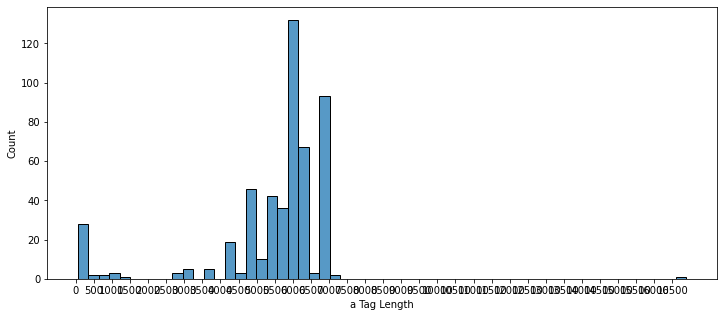

In [6]:
all_a_tags = soup.find_all('a')
len_a_tags = np.array([len(str(x)) for x in all_a_tags])

fig, ax = plt.subplots(figsize = (12,5))
plt.xlabel('a Tag Length')
plt.xticks(np.arange(0, max(len_a_tags), 500))
sns.histplot(len_a_tags, ax = ax)

Given the above, if there are no restaurants with between 500 and 1000 characters, would assume they all have over a 1000 characters.

In [9]:
# Is 500 a good cutoff?

[x for x in all_a_tags if len(str(x)) < 500]

[<a aria-label="Learn more about the cookies we use" class="banner-policy-link" href="https://deliveroo.co.uk/cookies">Learn more about the cookies we use</a>,
 <a aria-label="More Information" href="https://deliveroo.co.uk/cookies" onclick="Optanon.TriggerGoogleAnalyticsEvent('OneTrust Cookie Consent', 'Preferences Cookie Policy');" target="_blank">More Information</a>,
 <a href="https://onetrust.com/poweredbyonetrust" rel="noopener" target="_blank"><div alt="OneTrust Website" id="optanon-popup-bottom-logo" style="background: url(https://cdn.cookielaw.org/skins/6.15.0/default_flat_bottom_two_button_black/v2/images/cookie-collective-top-bottom.png);width:155px;height:35px;" title="powered by OneTrust"></div></a>,
 <a class="ccl-1b0ffd1d711941bf" href="/">Deliveroo</a>,
 <a class="HomeFeedFilters-debdd8f99b2be851" href="#filters-modal"><span class="ccl-462400680c526774 ccl-ed34b65f78f16205"><svg class="ccl-0f24ac4b87ce1f67 ccl-ed34b65f78f16205 ccl-c738ab1fde928049" height="24" viewbox="

In [11]:
[x for x in all_a_tags if len(str(x)) > 500 and len(str(x)) < 1000]

[<a class="ccl-985cb265c6f6a9c1" href="/login?redirect=%2Frestaurants%2Flondon%2Fwestminster%2F%3Fpostcode%3DSW1A%25202AA%26collection%3Dall-restaurants"><span class="ccl-c7e8470a1e905a95"><span class="ccl-462400680c526774 ccl-ed34b65f78f16205"><svg class="ccl-0f24ac4b87ce1f67 ccl-ed34b65f78f16205 ccl-c738ab1fde928049" height="24" viewbox="0 0 24 24" width="24"><path d="M3 10L5 8.44444V5H9.42857L12 3L21 10V21H3V10ZM14 19H19V10.9782L12 5.53372L5 10.9782V19H10V14H14V19Z"></path></svg></span><span class="ccl-19882374e640f487 ccl-417df52a76832172 ccl-deab34eb04186352 ccl-d20a5732188988de ccl-6a536dee6972c57c"><span class="ccl-19882374e640f487 ccl-1daa0367dee37c3b ccl-a5fb02a1085896d3 ccl-b308a2db3758e3e5">Sign up or log in</span></span></span></a>,
 <a class="ccl-f65f6247029a98f7 ccl-f41807dbd86452ba" href="https://www.facebook.com/deliveroo.uk" rel="noopener noreferrer" target="_blank" title="Facebook"><span class="ccl-462400680c526774 ccl-abe5c41af1b9498e"><svg class="ccl-0f24ac4b87ce1f6

In [13]:
[x for x in all_a_tags if len(str(x)) > 1000]

[<a aria-label="Restaurant Margarita Mama's. Delivers in 10 to 10 minutes. Rated 4.1 from 500+ reviews. Serves Italian, Pasta, and Pizza." class="HomeFeedUICard-1cc6964985e41c86" href="/menu/london/willesden/margarita-mamas?day=today&amp;postcode=SW1A2AA&amp;time=ASAP"><span class="HomeFeedUICard-ebc18e264cc4b96c"><span class="HomeFeedUICard-c6f6e82a465d3148" style="border-style:solid;border-top-color:initial;border-right-color:initial;border-bottom-color:initial;border-left-color:initial"><div class="ccl-45bd106b75353ec9" role="img" style='background-image: url("https://rs-menus-api.roocdn.com/images/efe60c29-6f8c-4eb4-85ae-cf3d640d7e18/image.jpeg?width=215&amp;height=121&amp;auto=webp&amp;format=jpg&amp;fit=crop&amp;v=");'><div class="ccl-d5fa9efd412993ea ccl-0220f29e0da451eb"></div><div class="ccl-0ca6410c5e153903"><div class="HomeFeedUICard-19d5d31598e0335f"><div class="HomeFeedUICard-dce4e0d3970c801d" style="background-color:initial"><div class="HomeFeedUICard-983872f50903bf3c" st

Looks like restaurants start to appear when we look above 1000. However, there is also a non-restaurant link. We can notice this does not contain an aria-label html attribute, so we filter out all a tags without this attribute and which are shorter than 1000 characters.

In [14]:
# Define a function that returns only if the tag is an 'a' tag and the 'a' tag has the aria-label attribute

def has_aria_label(tag):
    if tag.name == 'a':
        return tag.has_attr('aria-label')

In [15]:
potential_restaurants = soup.find_all(has_aria_label)
restaurants_html = [str(x) for x in potential_restaurants if len(str(x)) > 500 ]

In [16]:
restaurants_html[0]

'<a aria-label="Restaurant Margarita Mama\'s. Delivers in 10 to 10 minutes. Rated 4.1 from 500+ reviews. Serves Italian, Pasta, and Pizza." class="HomeFeedUICard-1cc6964985e41c86" href="/menu/london/willesden/margarita-mamas?day=today&amp;postcode=SW1A2AA&amp;time=ASAP"><span class="HomeFeedUICard-ebc18e264cc4b96c"><span class="HomeFeedUICard-c6f6e82a465d3148" style="border-style:solid;border-top-color:initial;border-right-color:initial;border-bottom-color:initial;border-left-color:initial"><div class="ccl-45bd106b75353ec9" role="img" style=\'background-image: url("https://rs-menus-api.roocdn.com/images/efe60c29-6f8c-4eb4-85ae-cf3d640d7e18/image.jpeg?width=215&amp;height=121&amp;auto=webp&amp;format=jpg&amp;fit=crop&amp;v=");\'><div class="ccl-d5fa9efd412993ea ccl-0220f29e0da451eb"></div><div class="ccl-0ca6410c5e153903"><div class="HomeFeedUICard-19d5d31598e0335f"><div class="HomeFeedUICard-dce4e0d3970c801d" style="background-color:initial"><div class="HomeFeedUICard-983872f50903bf3c"

# Data Cleaning

Now we have all of our restaurant information stored in our restaurants_html variable. Each restaurant's data is stored within the html file which we have saved as a string, but it is mixed in with a lot of useless text. Therefore, we will need to clean our data to get it into a form we can actually analyse. If you have a look at the other restaurants, you can see their data all follows a similar structure within the html string. We also want the hyperlink of each restaurant for our Egg Fried Rice analysis.

Looking at the above, we can see that the main data is available after the word 'Restaurant' and ends at a speech mark ("). Because Python strings can start with either single or double quotes, we will need make sure not to get mixed up. Distance data can be found near the phrase 'miles away' or at a special edge case of 'mile away', when the distance is 1 mile. Delivery cost will be found near a pound sign '£' and end at the word 'delivery'. A really helpful string method is the 'find' method. It returns the index where a substring starts in a string. If the substring can't be found, it returns -1. 

Once we've made functions to extract the data using these identifying strings, we can iterate over our array of restaurant data and pick out the bits we need. We'll then store this as a pandas dataframe

In [17]:
def find_hyperlink(text):
    hyperlink = 'http://deliveroo.co.uk'
    start_identifier = 'href="'
    end_identifier = '"' # I use single quotes to declare the string to make it clearer
    search_start = text.find(start_identifier) + len(start_identifier)
    search_end = text.find(end_identifier, search_start + len(start_identifier))
    query_string = text[search_start: search_end]
    return hyperlink + query_string

In [18]:
def find_main_data(text):
    start_identifier = 'Restaurant '
    end_identifier = '"'
    search_start = text.find(start_identifier) + len(start_identifier)
    search_end = text.find(end_identifier, search_start)
    return text[search_start:search_end]

In [19]:
# If '1 mile away', need to move back 2 characters from the start of 'mile away'
# If 'x.xx miles away', need to move back 4 characters from the start of 'miles away'

def find_distance_data(text):
    identifier = 'miles away'
    sub_identifier = 'mile away'
    start_index = text.find(identifier)
    
    if start_index == -1:
        sub_start_index = text.find(sub_identifier)
        search_start = sub_start_index -2
        search_end = search_start + 2 + len(sub_identifier)
    else:
        search_start = text.find(identifier) -4
        search_end = search_start + 4 + len(identifier)
    return text[search_start: search_end]

In [20]:
# If no pound sign found, assume free delivery
# If the text contains free delivery, then the cost should be 0
# If the text doesn't contain a pound sign or the word 'delivery', then it's likely the restaurant isn't delivering at the moment 
   
def find_delivery_cost(text):
    start_identifier = '£'
    end_identifier = 'delivery'
    search_start = text.find(start_identifier)
    search_end = text.find(end_identifier, search_start)
    if 'Free delivery' in text:
        return '£0.00'
    elif (search_start == -1) | (search_end == -1):
        return None
    else:
        return text[search_start: search_end - 1]

In [21]:
restaurants_list = []
rank = 1
for restaurant in restaurants_html:
    restaurant_dictionary = {
        'url': find_hyperlink(restaurant),
        'rank': rank,
        'main_data': find_main_data(restaurant),
        'distance': find_distance_data(restaurant),
        'delivery_cost': find_delivery_cost(restaurant)
    }
    restaurants_list.append(restaurant_dictionary)
    rank += 1   

restaurant_df = pd.DataFrame.from_dict(restaurants_list)
restaurant_df

,url,rank,main_data,distance,delivery_cost
0,http://deliveroo.co.uk/menu/london/willesden/m...,1,Margarita Mama's. Delivers in 10 to 10 minutes...,5.7 miles away,£0.00
1,http://deliveroo.co.uk/menu/london/marylebone/...,2,Simple Health Kitchen. Delivers in 15 to 30 mi...,1.6 miles away,£0.00
2,http://deliveroo.co.uk/menu/london/leicester-s...,3,Delivered by Eatime 小食代. Delivers in 25 to 25 ...,0.6 miles away,£0.00
3,http://deliveroo.co.uk/menu/london/victoria/bl...,4,Bleecker Burger. Delivers in 15 to 30 minutes....,0.9 miles away,£0.00
4,http://deliveroo.co.uk/menu/london/chelsea/pre...,5,Pret a Manger. Delivers in 20 to 35 minutes. R...,1.7 miles away,£0.00
...,...,...,...,...,...
464,http://deliveroo.co.uk/menu/london/soho/mildre...,465,Mildreds - Vegan. Delivers at 13:00. Rated 4.8...,0.8 miles away,£0.00
465,http://deliveroo.co.uk/menu/london/fitzrovia/a...,466,Arros QD Wines. Delivers at 13:00. Rated 4.9 f...,1 mile away,£0.00
466,http://deliveroo.co.uk/menu/london/fitzrovia/t...,467,Arros QD. Delivers at 13:00. Rated 4.4 from 50...,1 mile away,£0.00
467,http://deliveroo.co.uk/menu/london/st-paul's/p...,468,Pilpel for the People. Delivers at 15:45. Rate...,1.5 miles away,£0.00


In [22]:
# It's helpful to see what main_data actually looks like

restaurant_df['main_data'][0]

"Margarita Mama's. Delivers in 10 to 10 minutes. Rated 4.1 from 500+ reviews. Serves Italian, Pasta, and Pizza."

Voila! We're really starting to get there! Now we just need to transform our data so we can use it for analysis!

We'll need to do the following: 

1. Extract restaurant name, delivery time, reviews and cuisines from the main data column
2. Make sure all of our data is usable for analysis

In [23]:
# Sentence Tokenize from nltk seperates the main data into sentences, making it easier to get each bit of data

restaurant_df['restaurant_name'] = restaurant_df['main_data'].map(lambda x: sent_tokenize(x.replace('&amp;', '&'))[0][:-1].strip())
restaurant_df['delivery_time'] = restaurant_df['main_data'].map(lambda x: sent_tokenize(x)[1].split(' ')[2:5])

In [25]:
# We want to get the review score and the number of reviews
# Restaurants with 500 or more reviews just say 500+ reviews

def find_review_data(main_data):
    start_identifier = 'Rated '
    end_identifier = 'reviews'
    search_start = main_data.find(start_identifier)
    if search_start > -1:
        search_end = main_data.find(end_identifier, search_start) - 1
        review_data = main_data[search_start: search_end]
        review_score = float(review_data.split(' ')[1])
        review_number = int(review_data.split(' ')[-1].split('+')[0])
        return {'score': review_score, 'number': review_number} 
    else:
        return {'score': None, 'number': None }
    
restaurant_df['rating_score'] = restaurant_df['main_data'].map(lambda x: find_review_data(x)['score'])
restaurant_df['rating_number'] = restaurant_df['main_data'].map(lambda x: find_review_data(x)['number'])

Finding the cuisine data deserves a special mention. From the above, we can see the cuisines start after the word 'Serves'. Most cuisines can also be split on a comma, then the word 'and'. However, there is a very vital edge case...

If there are only two cuisines, there will be no comma and it will look like so 'Serves Chinese and Burgers'. So we will need to split on the word 'and'. BUT, if the cuisine is 'Fish and Chips', this will seperate 'Fish' and 'Chips' into seperate cuisines, which we don't want. Therefore, we need to slightly alter 'Fish and Chips' so we don't split it into 'Fish' and 'chips' by mistake.

In [26]:
# If any other cuisine has 'and' in the name, we will need to replace that too

def find_cuisine_data(main_data):
    start_identifier = 'Serves '
    first_split = ', '
    second_split = ' and '
    cuisine_list = []
    main_data = main_data.replace('Fish and chips', 'Fish*and*chips')
    cuisine_start = main_data.find(start_identifier)
    if cuisine_start > -1:
        cuisine_data = main_data[cuisine_start + len(start_identifier): -1]
        cuisine_list = cuisine_data.split(first_split)
        
        if len(cuisine_list) > 1:
            cuisine_list[-1] = cuisine_list[-1][len(second_split) - 1:]
            
        else:
            cuisine_string = ''.join(cuisine_list)
            cuisine_list = cuisine_string.split(second_split)
    
        return [cuisine.replace('Fish*and*chips', 'Fish and chips') for cuisine in cuisine_list]
    
    else: 
        return None
        
restaurant_df['cuisines'] = restaurant_df['main_data'].map(lambda x: find_cuisine_data(x))
restaurant_df.head()

,url,rank,main_data,distance,delivery_cost,restaurant_name,delivery_time,rating_score,rating_number,cuisines
0,http://deliveroo.co.uk/menu/london/willesden/m...,1,Margarita Mama's. Delivers in 10 to 10 minutes...,5.7 miles away,£0.00,Margarita Mama's,"[10, to, 10]",4.1,500.0,"[Italian, Pasta, Pizza]"
1,http://deliveroo.co.uk/menu/london/marylebone/...,2,Simple Health Kitchen. Delivers in 15 to 30 mi...,1.6 miles away,£0.00,Simple Health Kitchen,"[15, to, 30]",4.9,500.0,"[Burgers, Chicken, Salads, British]"
2,http://deliveroo.co.uk/menu/london/leicester-s...,3,Delivered by Eatime 小食代. Delivers in 25 to 25 ...,0.6 miles away,£0.00,Delivered by Eatime 小食代,"[25, to, 25]",4.1,45.0,"[Asian, Chinese, Seafood, BBQ]"
3,http://deliveroo.co.uk/menu/london/victoria/bl...,4,Bleecker Burger. Delivers in 15 to 30 minutes....,0.9 miles away,£0.00,Bleecker Burger,"[15, to, 30]",4.8,500.0,"[Burgers, American, Milkshakes]"
4,http://deliveroo.co.uk/menu/london/chelsea/pre...,5,Pret a Manger. Delivers in 20 to 35 minutes. R...,1.7 miles away,£0.00,Pret a Manger,"[20, to, 35]",4.8,500.0,"[Salads, Breakfast, Sandwiches, Healthy]"


Now we have all of our data, we need to make it usable. 

1. distance should be a float, not a string
2. delivery_cost should be a float, not a string
3. delivery_time should actually be split into min, max and average delivery time and should all be floats
4. Each cuisine should have its own column equal to 1 if the restaurant serves that cuisine, and 0 otherwise
5. We will need to remove all unnecessary columns

In [27]:
restaurant_df['distance_miles'] = restaurant_df['distance'].map(lambda x: float(x.split(' ')[0]) if x else None)

In [28]:
restaurant_df['delivery_cost_pounds'] = restaurant_df['delivery_cost'].map(lambda x: float(x[1:]) if x else None)

In [41]:
# Take the first and last element of delivery_time, and also get their average
# If delivery time is empty, the restaurant must be closed
# We can only do this where the delivery time has 3 elements and the first and last element start with a digit

def clean_delivery_data(delivery_time):
    
    min_time = 'closed'
    max_time = 'closed'
    avg_time = 'closed'
    
    if len(delivery_time) > 1:
        if (delivery_time[0][0].isdigit()) & (len(delivery_time) == 3) :
            min_time = float(delivery_time[0])
            max_time = float(delivery_time[-1])
            avg_time = np.mean([min_time, max_time])
            
    return {'min': min_time, 'max': max_time, 'avg': avg_time}

restaurant_df['min_delivery_time'] = restaurant_df['delivery_time'].map(lambda x: clean_delivery_data(x)['min'])
restaurant_df['max_delivery_time'] = restaurant_df['delivery_time'].map(lambda x: clean_delivery_data(x)['max'])
restaurant_df['avg_delivery_time'] = restaurant_df['delivery_time'].map(lambda x: clean_delivery_data(x)['avg'])
restaurant_df['closed'] = restaurant_df['min_delivery_time'].map(lambda x: 1 if x == 'closed' else 0)

In [42]:
# Need to make dummy variables for each possible cuisine, so first we create a list of all the cuisines
# Then, make a new column for each cuisine, which is equal to 1 if the restaurant serves the cuisine and zero otherwise

cuisine_list = np.array([])
for cuisines in restaurant_df['cuisines']:
    if cuisines: 
        cuisine_list = np.append(cuisine_list, cuisines)
cuisine_list = pd.Series(np.sort(cuisine_list)).unique()

for cuisine in cuisine_list:
    restaurant_df[cuisine] = restaurant_df['cuisines'].map(lambda x: 1 if x and cuisine in x else 0)

In [43]:
# Let's have a look at what columns we have left

restaurant_df.columns

Index(['url', 'rank', 'main_data', 'distance', 'delivery_cost',
       'restaurant_name', 'delivery_time', 'rating_score', 'rating_number',
       'cuisines',
       ...
       'Thai', 'Turkish', 'Vietnamese', 'Wine', 'Wings', 'Wraps',
       'min_delivery_time', 'max_delivery_time', 'avg_delivery_time',
       'closed'],
      dtype='object', length=103)

In [44]:
# We don't need main_data, distance, delivery_cost, and delivery_time anymore

restaurant_df_clean = restaurant_df.drop(axis = 1, columns = ['main_data', 'distance', 'delivery_cost', 'delivery_time'])

In [45]:
restaurant_df_clean.head()

,url,rank,restaurant_name,rating_score,rating_number,cuisines,distance_miles,delivery_cost_pounds,Acai,Alcohol,...,Thai,Turkish,Vietnamese,Wine,Wings,Wraps,min_delivery_time,max_delivery_time,avg_delivery_time,closed
0,http://deliveroo.co.uk/menu/london/willesden/m...,1,Margarita Mama's,4.1,500.0,"[Italian, Pasta, Pizza]",5.7,0.0,0,0,...,0,0,0,0,0,0,10,10,10,0
1,http://deliveroo.co.uk/menu/london/marylebone/...,2,Simple Health Kitchen,4.9,500.0,"[Burgers, Chicken, Salads, British]",1.6,0.0,0,0,...,0,0,0,0,0,0,15,30,22.5,0
2,http://deliveroo.co.uk/menu/london/leicester-s...,3,Delivered by Eatime 小食代,4.1,45.0,"[Asian, Chinese, Seafood, BBQ]",0.6,0.0,0,0,...,0,0,0,0,0,0,25,25,25,0
3,http://deliveroo.co.uk/menu/london/victoria/bl...,4,Bleecker Burger,4.8,500.0,"[Burgers, American, Milkshakes]",0.9,0.0,0,0,...,0,0,0,0,0,0,15,30,22.5,0
4,http://deliveroo.co.uk/menu/london/chelsea/pre...,5,Pret a Manger,4.8,500.0,"[Salads, Breakfast, Sandwiches, Healthy]",1.7,0.0,0,0,...,0,0,0,0,0,0,20,35,27.5,0


In [46]:
restaurant_df_clean.describe()

,rank,rating_score,rating_number,distance_miles,delivery_cost_pounds,Acai,Alcohol,American,Argentinian,Asian,...,Taiwanese,Tapas,Tea,Thai,Turkish,Vietnamese,Wine,Wings,Wraps,closed
count,469.000000,447.000000,447.000000,466.000000,466.0,469.000000,469.000000,469.000000,469.000000,469.000000,...,469.000000,469.000000,469.000000,469.000000,469.000000,469.000000,469.000000,469.000000,469.000000,469.000000
mean,235.000000,4.591051,387.800895,1.288412,0.0,0.006397,0.121535,0.113006,0.006397,0.093817,...,0.012793,0.010661,0.004264,0.008529,0.008529,0.017058,0.029851,0.025586,0.029851,0.110874
std,135.532899,0.287342,174.106336,0.961179,0.0,0.079808,0.327097,0.316939,0.079808,0.291885,...,0.112501,0.102810,0.065233,0.092055,0.092055,0.129624,0.170357,0.158066,0.170357,0.314312
min,1.000000,2.100000,11.000000,0.300000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,118.000000,4.500000,267.000000,0.700000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,235.000000,4.700000,500.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,352.000000,4.800000,500.000000,1.700000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,469.000000,5.000000,500.000000,8.900000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Depending on when you scrape your data, the amount of null values can be very different. The number of restaurants may not match the webpage because we only look at restaurants which have links to them. Some restaurants on the webpage which are closed may not have links to them for a variety of reasons, so they won't be captured in our data.

My original goal was to only scrape data on restaurants which are currently delivering. If you do this in the morning, many restaurnts won't be delivering yet, and so their delivery time, cost and distance may not be there. If the webpage tells you when you can pre-order, it doesn't give a min/max delivery time.

In [47]:
# Save a version of the dataframe down which can be re-used, instead of having to scrape the data again
restaurant_df_clean.to_csv('last_scrape_clean', index= False)

# Exploratory Data Analysis 

Wow.. We've finally got here! Time to make some pretty graphs to gain some insights into our data! 

For example, what cuisine is most popular in the postcode? What cuisine has the best rating? Can we try to figure out how page rank is determined? 

In [48]:
# Making a helpful function that will help us calculate the number of restaurants serving each cuisine 

def return_cuisine_numbers(df, cuisine_list = cuisine_list):
    cuisine_columns = df[cuisine_list]
    cuisine_means_sorted = cuisine_columns.describe().loc['mean'].sort_values(ascending = False) * len(df)
    return cuisine_means_sorted

Text(0, 0.5, 'Number of Restaurants')

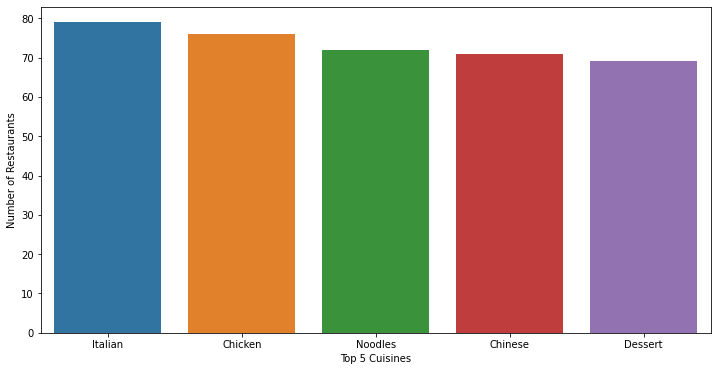

In [49]:
all_restaurant_cuisines = return_cuisine_numbers(restaurant_df_clean)

no_top = 5

plt.subplots(figsize = (12,6))
sns.barplot(x = all_restaurant_cuisines.head(no_top).index,y = all_restaurant_cuisines.head(no_top))
plt.xlabel(f'Top {no_top} Cuisines')
plt.ylabel('Number of Restaurants')

Remember: This is always going to vary depending on what time of day you run the script as the data is filtered down to restaurants which you can click onto on the webpage! Let's look at graphs for both open and closed places (bearing in mind that some closed places may be missing from the data)

/home/selvino/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='closed', ylabel='count'>

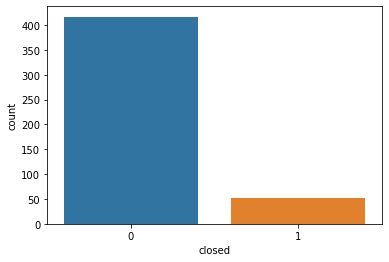

In [52]:
# Let's see what proportion of the restaurants are open
sns.countplot(restaurant_df_clean['closed'])

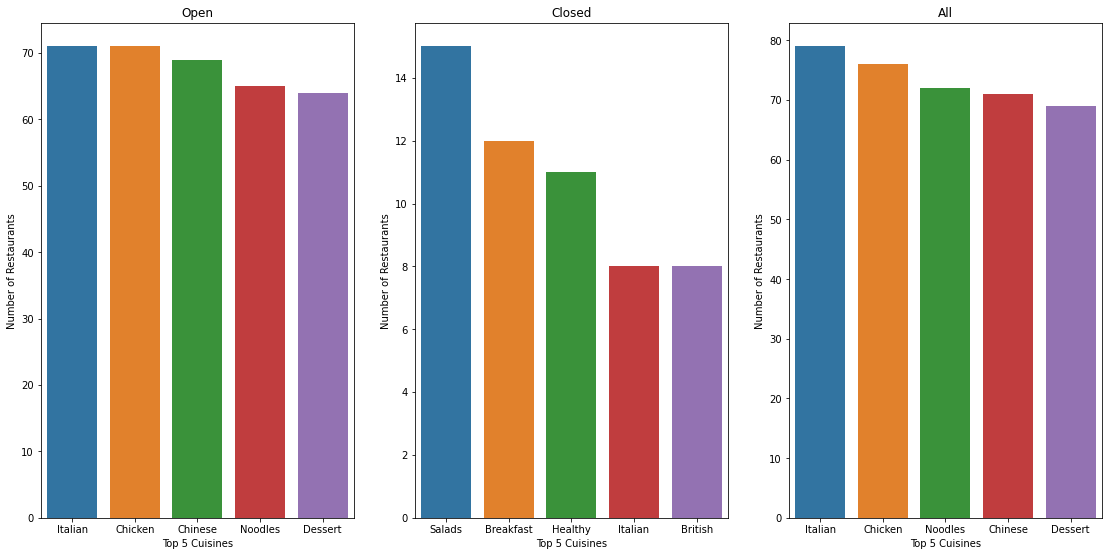

In [53]:
open_restaurant_cuisines = return_cuisine_numbers(restaurant_df_clean[restaurant_df_clean['closed'] == 0])
closed_restaurant_cuisines = return_cuisine_numbers(restaurant_df_clean[restaurant_df_clean['closed'] == 1])

no_top = 5

fig, ax = plt.subplots(1, 3, figsize = (16,8))
fig.tight_layout(pad = 3)
ax[0].title.set_text('Open')
ax[1].title.set_text('Closed')
ax[2].title.set_text('All')
sns.barplot(x = open_restaurant_cuisines.head(no_top).index,y = open_restaurant_cuisines.head(no_top), ax = ax[0])
sns.barplot(x = closed_restaurant_cuisines.head(no_top).index,y = closed_restaurant_cuisines.head(no_top), ax= ax[1])
sns.barplot(x = all_restaurant_cuisines.head(no_top).index,y = all_restaurant_cuisines.head(no_top))

for axes in ax:
    axes.set_xlabel(f'Top {no_top} Cuisines')
    axes.set_ylabel('Number of Restaurants')

### Question 2: What is the quality of food in postcode of interest?

In [54]:
round(np.mean(restaurant_df_clean['rating_score']),2)

4.59

Looks good!

### Question 3: How does quality vary by cuisine?

In [55]:
# To get the rating for each cuisine, we can multiply the rating number by the cuisine column
# If a restaurant serves that cuisine, the product will be non-zero
# Then we need to get rid of all observations where this product is 0, because it means that those restaurants don't serve that cuisine (assuming no restaurants with a zero rating exist)
# Then we take the average of ratings for that cuisine

cuisine_rating_means = np.array([])
for cuisine in cuisine_list:
    cuisine_ratings = restaurant_df_clean['rating_score'] * restaurant_df_clean[cuisine]
    cuisine_ratings = cuisine_ratings[cuisine_ratings > 0] 
    cuisine_rating_means = np.append(cuisine_rating_means, np.mean(cuisine_ratings))

cuisine_rating_means = pd.Series(cuisine_rating_means, index = cuisine_list)
cuisine_rating_means

Acai           4.800000
Alcohol        4.654545
American       4.553846
Argentinian    4.633333
Asian          4.647727
                 ...   
Turkish        4.525000
Vietnamese     4.687500
Wine           4.669231
Wings          4.500000
Wraps          4.508333
Length: 87, dtype: float64

What are the best and worst quality cuisines?

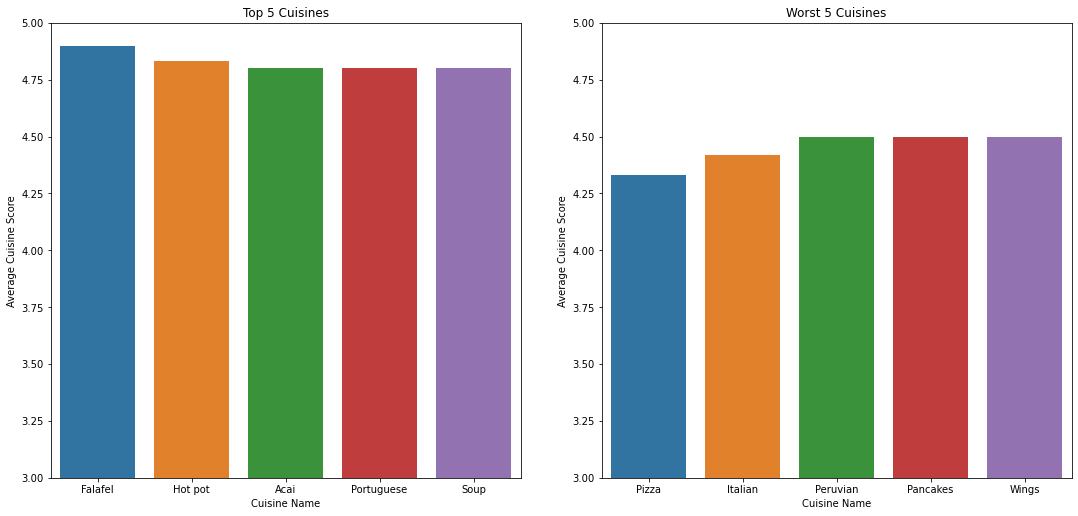

In [57]:
number_to_show = 5
best_cuisines = cuisine_rating_means.sort_values(ascending = False).head(number_to_show)
worst_cuisines = cuisine_rating_means.sort_values().head(number_to_show)

fig, ax = plt.subplots(1, 2, figsize = (16,8))
fig.tight_layout(pad = 5)
sns.barplot(x = best_cuisines.index, y = best_cuisines, ax = ax[0])
sns.barplot(x = worst_cuisines.index, y = worst_cuisines, ax = ax[1])
ax[0].title.set_text(f'Top {number_to_show} Cuisines')
ax[1].title.set_text(f'Worst {number_to_show} Cuisines')

for axes in ax:
    axes.set_xlabel('Cuisine Name')
    axes.set_ylabel('Average Cuisine Score')
    axes.set(ylim = (3, 5))

Looks like even the worse cuisines still have decent ratings on average... Maybe the quality of food on Deliveroo is just very good? Their selling point is that they have high quality restaurants on the platform. Deliveroo is recognised for having well-known or chain restaurants on the platform. 

### Question 4: Is there a relationship between order frequency and quality?

Assuming order frequencty can be proxied by the number of ratings, maybe we would expect restaurants with a higher score to have a higher order frequency and more ratings? This would suggest that rating score directly causes order frequency to rise. This causal hypothesis is something we cannot test due to data limitations. 

But still, it would be interesting to see if there is a relationship between rating score and number of ratings.

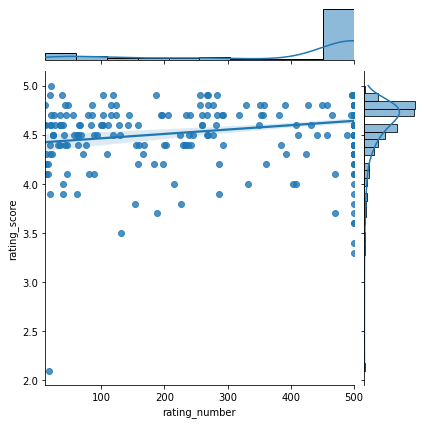

In [58]:
sns.jointplot(x = 'rating_number', y = 'rating_score', data = restaurant_df_clean, kind = 'reg')

Doesn't look like there is much of a relationship between the number of ratings and the rating score. One hypothesis for this is that ratings aren't really affecting the number of orders a restaurants get. As a result, we could argue that customers don't really look at reviews. This could be because ratings are so inflated on Deliveroo, that the customer is indifferent between them. For example, a restaurant being 4.1 or 4.5 may not matter much to the customer.

However, our data on the number of ratings is limited. This is because when a restaurant has 500 reviews or more, we have had to round the number down to 500. The restaurant does not show the exact number of reviews when it is above 500. We also do not have data on order frequency, we are using a (weak) proxy.

### Question 5: Is there a relationship between rating score and rank?

The rank of a restaurant on Deliveroo's website is so important because customers are not likely to scroll that far down to find a restaurant. It seems sensible to argue that restaurants near the top are likely to get more customers. Therefore, trying to understand how Deliveroo ranks the restaurants on the webpage is very important.

The ranking algorithm is also very important from Deliveroo's perspective. They want the best restaurants to be near the top, so that people order from them, have a good experience on Deliveroo, and then continue to order more in the future. If the restaurants at the top are bad, customers will have a bad experience and may be put off from ordering on Deliveroo again. Given Deliveroo earns comission on every order, they will want to maximise the number of orders they receive to increase revenue. Therefore, having an effective ranking algorithm is vital. 

This ranking algorithm is likely to be very complicated because it is so valuable. However, one could guess that a restaurant's rating score has something to do with it. 

<AxesSubplot:xlabel='rating_score', ylabel='rank'>

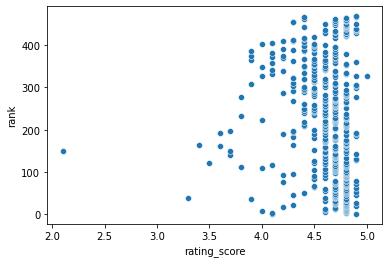

In [59]:
sns.scatterplot(x = 'rating_score', y = 'rank', data = restaurant_df_clean)

Given the above, it seems as if the ranking algorithm isn't strongly based on rating score. However, it is worth noting that in the above graph, there are few restaurants with a rating below 4 in the top 200. There are quite a lot more restaurants with a rating below 4 in the bottom 200 restaurants. 

Therefore, I would conclude that rating score plays some part in the ranking algorithm, but it definitely isn't a driving factor. There are so many more things going on in that black box!

# Egg Fried Rice Analysis

In [35]:
# For each hyperlink we have, search the phrase egg fried rice, and then get the price information
# We find all the dishes, then split them into their title, description and price

In [36]:
def scroll_entire_page(url):
    driver = webdriver.Chrome(executable_path=chrome_driver_path)
    driver.get(url)
    time.sleep(initial_load_time / 100)
    screen_height = driver.execute_script('return window.screen.height;')

    i = 1
    while True:
        driver.execute_script("window.scrollTo(0, {screen_height} * {i});".format(screen_height=screen_height, i = i))
        i += 1
        time.sleep(scroll_pause_time / 10000)
        scroll_height = driver.execute_script("return document.body.scrollHeight")
        if screen_height * i > scroll_height: 
            break

    html_page = str(BeautifulSoup(driver.page_source, 'html.parser'))
    driver.quit()
    return html_page

In [37]:
def find_dishes(text):
    dishes = []
    start_identifier = 'class="orderweb__0eecc2d3"'
    end_identifier = '</li>'
    search_start = text.find(start_identifier) + len(start_identifier)
    search_end = text.find(end_identifier, search_start) + len(end_identifier)
    
    while search_start != -1:
        search_end = text.find(end_identifier, search_start) + len(end_identifier)
        dishes.append(text[search_start: search_end])
        search_start = text.find(start_identifier, search_end)
    
    return dishes

In [38]:
# efr = egg fried rice

def get_efr_info(dish_data_list):
    for dish in dish_data_list:
        name_start_identifier = 'ccl-9d0a5327c911d0f3">'
        name_end_identifier = '</p>'
        price_start_identifier = '£'
        price_end_identifier = '<'

        name_start = dish.find(name_start_identifier) + len(name_start_identifier)
        name_end = dish.find(name_end_identifier, name_start)

        price_start = dish.find(price_start_identifier) + len(price_start_identifier)
        price_end = dish.find(price_end_identifier, price_start)
        
        name = dish[name_start: name_end]
        price = dish[price_start: price_end]
        
        if 'Egg Fried Rice' in name:
            return float(price)

In [39]:
restaurant_df_clean['efr_price'] = restaurant_df_clean['url'].map(lambda x: get_efr_info(find_dishes(scroll_entire_page(x))))

KeyboardInterrupt: 

In [ ]:
restaurant_df_clean.to_csv('with_efr_prices')

/home/selvino/.local/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='efr_price', ylabel='Density'>

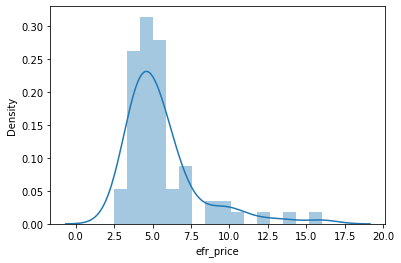

In [43]:
sns.distplot(pd.read_csv('with_efr_prices_hard_copy')['efr_price'])

In [44]:
pd.read_csv('with_efr_prices_hard_copy')['efr_price'].max()

16.0